# **redis-feast-gcp**: 01 - Triton Model Training

In this notebook, we will use the Feast SDK to pull historical data for training an `XGBoost` regression model. We'll then deploy that model to the NVIDIA Triton Inference Server model repository.

**This notebook assumes that you've already set up your Feature Store and model repo in GCP.**

![architecture](img/redis-feast-gcp-architecture.png)

# Fetching Historical Data

Similar to our first notebook, we can use Feast to prepare an accurate training dataset across several different feature views (tables).

To make things simpler, we use the [`DataFetcher`](utils/data_fetcher.py) class that wraps Feast, which wraps Redis and BigQuery.

In [1]:
from feature_store.repo import config
from feature_store.utils import (
    DataFetcher,
    storage
)

# Load fs
fs = storage.get_feature_store(
    config_path=config.REPO_CONFIG,
    bucket_name=config.BUCKET_NAME
)

# Load data fetcher
data_fetcher = DataFetcher(fs)

Feast is an open source project that collects anonymized error reporting and usage statistics. To opt out or learn more see https://docs.feast.dev/reference/usage


In [2]:
# Fetch Historical Training Data
ds = data_fetcher.get_training_data(
    entity_query=f"""
        select
            state,
            date as event_timestamp
        from
            {config.BIGQUERY_DATASET_NAME}.{config.WEEKLY_VACCINATIONS_TABLE}
    """
)

# Clean up any nulls
ds.dropna(inplace=True)
ds.sort_values(['event_timestamp', 'state'], axis=0, inplace=True)

## Exploratory Data Prep and Analysis

We won't do too much here. The point is to demonstrate the correlation between our features and the target value (`weekly_vaccinations_count`)

In [3]:
# Grab a subset of data
virginia = ds[ds.state == "Virginia"]

2023-02-06 16:56:22,672:          font_manager.py:1633              _load_fontmanager(): generated new fontManager


<AxesSubplot: xlabel='lag_2_vaccine_interest', ylabel='weekly_vaccinations_count'>

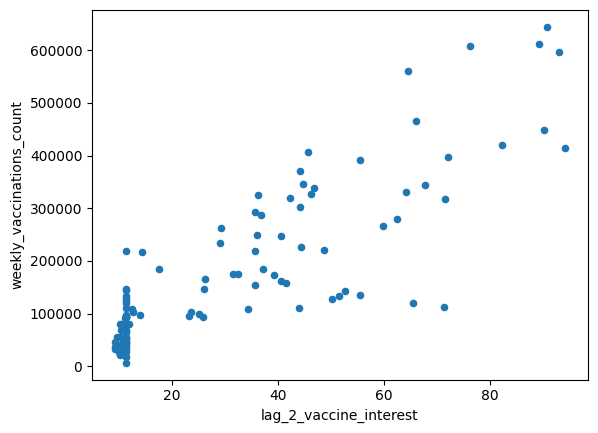

In [4]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_interest')

<AxesSubplot: xlabel='lag_2_vaccine_safety', ylabel='weekly_vaccinations_count'>

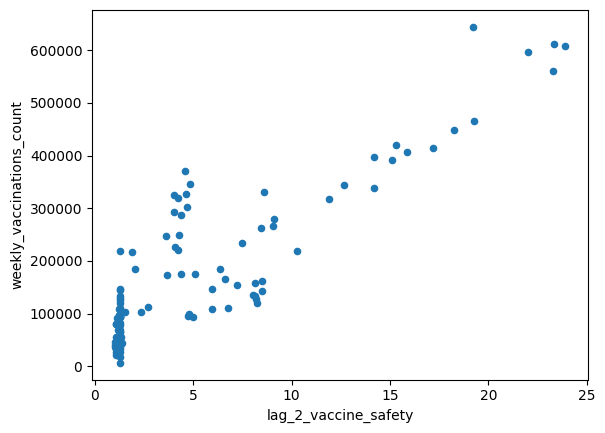

In [5]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_safety')

<AxesSubplot: xlabel='lag_2_vaccine_intent', ylabel='weekly_vaccinations_count'>

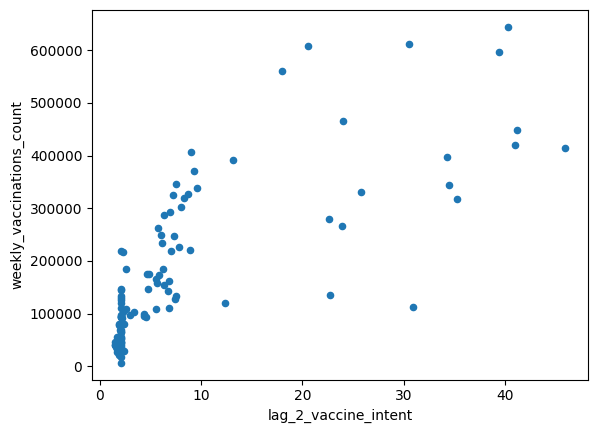

In [6]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_intent')

<AxesSubplot: xlabel='lag_1_weekly_vaccinations_count', ylabel='weekly_vaccinations_count'>

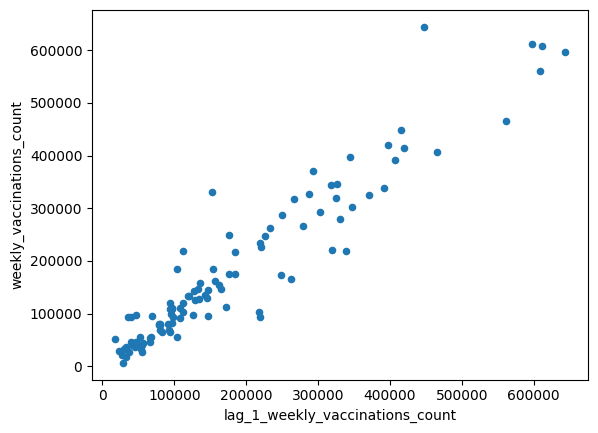

In [7]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_1_weekly_vaccinations_count')

# Model Training

Use loaded features to train an XGboost regression model.

In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from xgboost import XGBRegressor
from feature_store.repo import config
from feature_store.utils import (
    DataFetcher,
    logger,
    storage
)

logging = logger.get_logger()

In [9]:
def train_test_split(
    data: pd.DataFrame,
    n: int,
    timestamp_col: str,
    by: str = "week"
):
    """
    Split a timeseries dataset into train/test sets by date.

    Args:
        data (pd.DataFrame): _description_
        n (int): _description_
        timestamp_col (str): _description_
        by (str, optional): _description_. Defaults to "week".

    Raises:
        ValueError: If "by" arg is not one of "week" or "day".
    """
    if by == "week":
        delta = timedelta(weeks=n)
    elif by == "day":
        delta == timedelta(days=n)
    else:
        raise ValueError("'by' must be one of 'week' or day'")
    # Split the data
    split_point = data[timestamp_col].max() - delta
    train = data[data[timestamp_col] <= split_point]
    test = data[data[timestamp_col] > split_point]
    train.drop(columns=[timestamp_col, "state"], axis=1, inplace=True)
    test.drop(columns=[timestamp_col, "state"], axis=1, inplace=True)
    logging.info(f"Training Results: {len(train)} samples in the training set")
    return train, test

def xgboost_train(train: pd.DataFrame, test: pd.DataFrame = None):
    """
    Train an XGBoost.

    Args:
        train (pd.DataFrame): Training DataFrame.
        test (pd.DataFrame): Testing DataFrame. (Optional)
    """
    # split into input and output columns
    train = train.to_numpy()
    trainX, trainy = train[:, :-1], train[:, -1]

    # make xgboost regressor model
    model = XGBRegressor(
        random_state=42,
        objective="count:poisson",
        tree_method="hist",
        eval_metric="mae",
        n_estimators=250,
        max_depth=4
    )
    if isinstance(test, pd.DataFrame):
        test = test.to_numpy()
        testX, testy = test[:, :-1], test[:, -1]
        return model.fit(
            trainX,
            trainy,
            eval_set=[(testX, testy)]
        )
    return model.fit(trainX, trainy)

In [10]:
# Init feature store and data fetcher
logging.info("Loading feature store and data fetcher")

store = storage.get_feature_store(
    config_path=config.REPO_CONFIG,
    bucket_name=config.BUCKET_NAME
)

data_fetcher = DataFetcher(store)

2023-02-06 16:56:24,145:            1813428075.py:  2                 <cell line: 2>(): Loading feature store and data fetcher


In [11]:
# Train/Test split for validation
train, test = train_test_split(
    data=ds,
    n=1,
    timestamp_col="event_timestamp"
)

# Train initial model
model = xgboost_train(
    train[data_fetcher.X_cols + data_fetcher.y_col],
    test[data_fetcher.X_cols + data_fetcher.y_col]
)

2023-02-06 16:56:25,068:            2732332105.py: 31               train_test_split(): Training Results: 5250 samples in the training set


[0]	validation_0-mae:4147.46316
[1]	validation_0-mae:4147.31908
[2]	validation_0-mae:4147.14116
[3]	validation_0-mae:4146.92180
[4]	validation_0-mae:4146.65121
[5]	validation_0-mae:4146.31728
[6]	validation_0-mae:4145.90536
[7]	validation_0-mae:4145.39725
[8]	validation_0-mae:4144.77035
[9]	validation_0-mae:4143.99693
[10]	validation_0-mae:4143.04284
[11]	validation_0-mae:4141.86567
[12]	validation_0-mae:4140.41354
[13]	validation_0-mae:4138.62206
[14]	validation_0-mae:4136.41198
[15]	validation_0-mae:4133.68542
[16]	validation_0-mae:4130.32168
[17]	validation_0-mae:4126.17191
[18]	validation_0-mae:4121.05260
[19]	validation_0-mae:4114.87053
[20]	validation_0-mae:4107.39062
[21]	validation_0-mae:4098.16283
[22]	validation_0-mae:4086.77874
[23]	validation_0-mae:4072.73441
[24]	validation_0-mae:4055.40813
[25]	validation_0-mae:4034.03314
[26]	validation_0-mae:4007.66328
[27]	validation_0-mae:3975.13146
[28]	validation_0-mae:3934.99755
[29]	validation_0-mae:3885.48533
[30]	validation_0-ma

In [12]:
logging.info(f"Initial model training complete. Validation loss observed.")

# Train final model
model = xgboost_train(ds[data_fetcher.X_cols + data_fetcher.y_col])
logging.info("Final model trained.")

2023-02-06 16:56:26,225:            1889519271.py:  1                 <cell line: 1>(): Initial model training complete. Validation loss observed.
2023-02-06 16:56:26,467:            1889519271.py:  5                 <cell line: 5>(): Final model trained.


In [15]:
# Save model to the local Triton Model Repo
model_version = 1
model_path = f"./docker/triton/models/{config.MODEL_NAME}/{model_version}/{config.MODEL_FILENAME}"
model.save_model(model_path)

In [16]:
# Explore feature importance
for feature, imp in zip(data_fetcher.X_cols, model.feature_importances_):
    print(feature, imp)

lag_1_vaccine_interest 0.00928431
lag_2_vaccine_interest 0.0062543144
lag_1_vaccine_intent 0.008840547
lag_2_vaccine_intent 0.009353174
lag_1_vaccine_safety 0.014894915
lag_2_vaccine_safety 0.00739403
lag_1_weekly_vaccinations_count 0.9215164
lag_2_weekly_vaccinations_count 0.02246229


## Upload to Triton Model Repository

This E2E example uses **GCP Cloud Storage** for the **Triton Model Repository**. Most likely, you've already run the setup container which would have generated the initial model repository in your GCP project. Now that we have a "new" model, we can deploy and update the model in the repo.

In [ ]:
from google.cloud import storage

remote_model_path = f"models/{config.MODEL_NAME}/{model_version}/{config.MODEL_FILENAME}"

client = storage.Client()
bucket = client.bucket(config.BUCKET_NAME)
blob = bucket.blob(remote_model_path)
blob.upload_from_filename(model_path)

In [ ]:
# Here is the whole model repo spelled out
[b for b in bucket.list_blobs() if "models" in b.name]

If you restart your Vertex model in the GCP dashboard -- you should get the latest models from GCS copied to your Triton container running in Vertex

*Since Triton version 22.07 there is a bug in accessing GCS as the model repo. This will be fixed in v23.01 and we will update the example accordingly.*